In [1]:
library(rpart)
library(rpart.plot)
library(Amelia)

Loading required package: Rcpp

## 
## Amelia II: Multiple Imputation
## (Version 1.7.6, built: 2019-11-24)
## Copyright (C) 2005-2021 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 



In [2]:
data = read.csv('../../Data/baseball.csv')

In [3]:
head(data)

,Name,Team,Position,Height,Weight,Age,PosCategory
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>
1,Adam_Donachie,BAL,Catcher,74,180,22.99,Catcher
2,Paul_Bako,BAL,Catcher,74,215,34.69,Catcher
3,Ramon_Hernandez,BAL,Catcher,72,210,30.78,Catcher
4,Kevin_Millar,BAL,First_Baseman,72,210,35.43,Infielder
5,Chris_Gomez,BAL,First_Baseman,73,188,35.71,Infielder
6,Brian_Roberts,BAL,Second_Baseman,69,176,29.39,Infielder


In [4]:
print(paste("cols:", ncol(data)))
print(paste("rows:", nrow(data)))

[1] "cols: 7"
[1] "rows: 1015"


In [5]:
data["Height"] = data["Height"] * 0.0254
data["Weight"] = data["Weight"] * 0.453592

In [6]:
print("After preprocessing data:")
head(data)

[1] "After preprocessing data:"


,Name,Team,Position,Height,Weight,Age,PosCategory
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,Adam_Donachie,BAL,Catcher,1.8796,81.64656,22.99,Catcher
2,Paul_Bako,BAL,Catcher,1.8796,97.52228,34.69,Catcher
3,Ramon_Hernandez,BAL,Catcher,1.8288,95.25432,30.78,Catcher
4,Kevin_Millar,BAL,First_Baseman,1.8288,95.25432,35.43,Infielder
5,Chris_Gomez,BAL,First_Baseman,1.8542,85.27530,35.71,Infielder
6,Brian_Roberts,BAL,Second_Baseman,1.7526,79.83219,29.39,Infielder


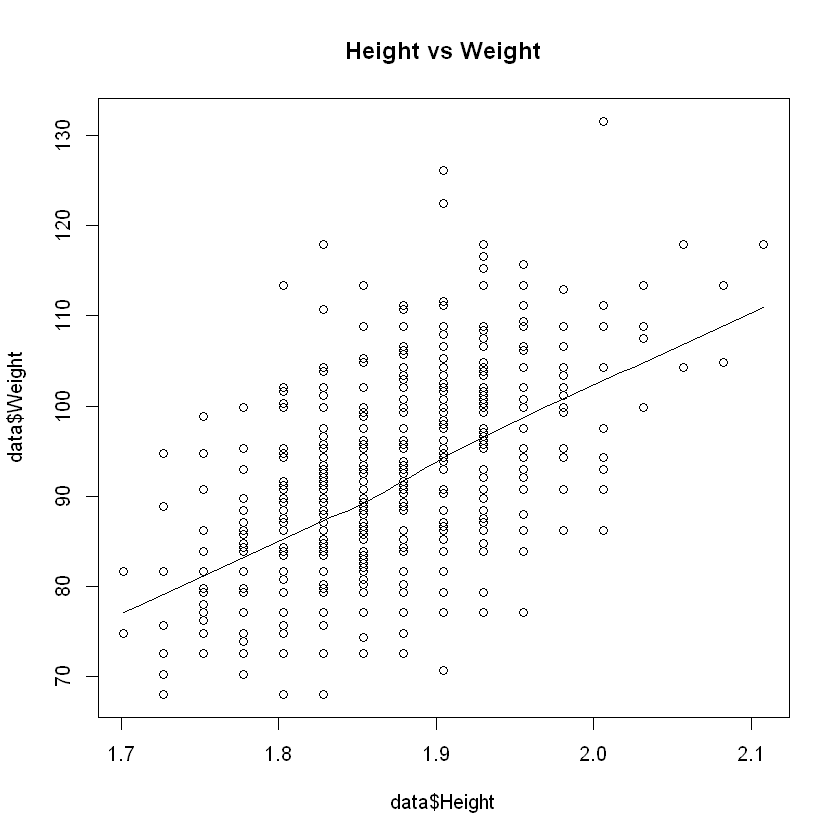

In [7]:
scatter.smooth(x = data$Height, y = data$Weight, main = "Height vs Weight")

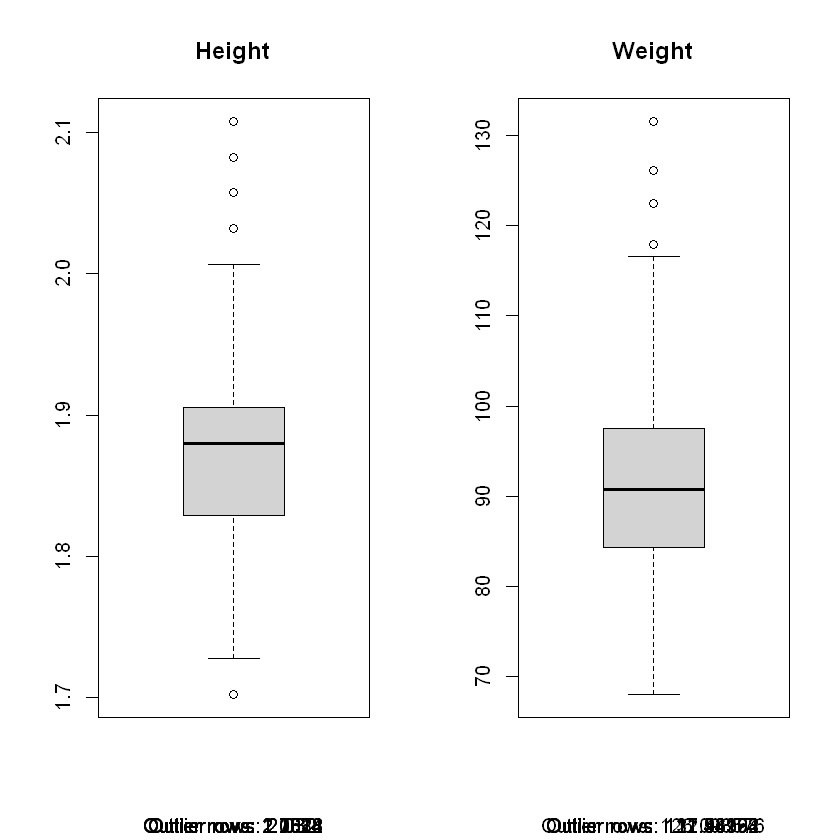

In [8]:
# Boxplot to Check for outliers
par(mfrow = c(1, 2)) # Divide graph area in 2 columns
boxplot(data$Height, main = "Height", 
        sub = paste("Outlier rows:", boxplot.stats(data$Height)$out))
boxplot(data$Weight, main = "Weight", 
        sub = paste("Outlier rows:", boxplot.stats(data$Weight)$out))

In [9]:
# Calculate correlation between Width and Length
print(paste("correlation:", cor(data$Height, data$Weight)))
print("wt_outliers:")
print(boxplot.stats(data$Weight)$out)
print("ht_outliers:")
print(boxplot.stats(data$Height)$out)

[1] "correlation: 0.531539322614609"
[1] "wt_outliers:"
[1] 117.9339 122.4698 131.5417 126.0986 117.9339 117.9339 117.9339
[1] "ht_outliers:"
 [1] 2.0574 2.0320 2.0320 2.0320 2.0320 2.0828 2.0320 2.0574 2.0828 2.1082
[11] 1.7018 1.7018


In [10]:
# Drop rows have outliers
print(paste("Before drop:", nrow(data)))
for (record in boxplot.stats(data$Weight)$out){
    data = data[data$Weight != record, ]
}
for (record in boxplot.stats(data$Height)$out){
    data = data[data$Height != record, ]
}
print(paste("After drop:", nrow(data)))

[1] "Before drop: 1015"
[1] "After drop: 998"


In [11]:
# Create training and test data samples from orginal data
set.seed(42) # Setting seed to reproduce results of ramdom sampling
trainingRowIndex = sample(1: nrow(data), 0.7 * nrow(data))
print("Selected training row indexes:")
trainingData = data[trainingRowIndex, ]
testData = data[- trainingRowIndex,]
print("Rows of training data and test data:")
print(nrow(trainingData))
print(nrow(testData))

[1] "Selected training row indexes:"
[1] "Rows of training data and test data:"
[1] 698
[1] 300


In [12]:
baseball.tree = rpart(Weight ~ Height,
                  data = trainingData, method = "anova")
summary(baseball.tree)

Call:
rpart(formula = Weight ~ Height, data = trainingData, method = "anova")
  n= 698 

          CP nsplit rel error    xerror       xstd
1 0.15717992      0 1.0000000 1.0032151 0.04888121
2 0.02896649      1 0.8428201 0.8747585 0.04657139
3 0.02483727      2 0.8138536 0.8720701 0.04630771
4 0.01126342      3 0.7890163 0.8338157 0.04438520
5 0.01000000      4 0.7777529 0.8290693 0.04417677

Variable importance
Height 
   100 

Node number 1: 698 observations,    complexity param=0.1571799
  mean=90.84057, MSE=80.12391 
  left son=2 (340 obs) right son=3 (358 obs)
  Primary splits:
      Height < 1.8669 to the left,  improve=0.1571799, (0 missing)

Node number 2: 340 observations,    complexity param=0.02483727
  mean=87.19906, MSE=62.91233 
  left son=4 (223 obs) right son=5 (117 obs)
  Primary splits:
      Height < 1.8415 to the left,  improve=0.06493916, (0 missing)

Node number 3: 358 observations,    complexity param=0.02896649
  mean=94.29899, MSE=71.91557 
  left son=6 (226 ob

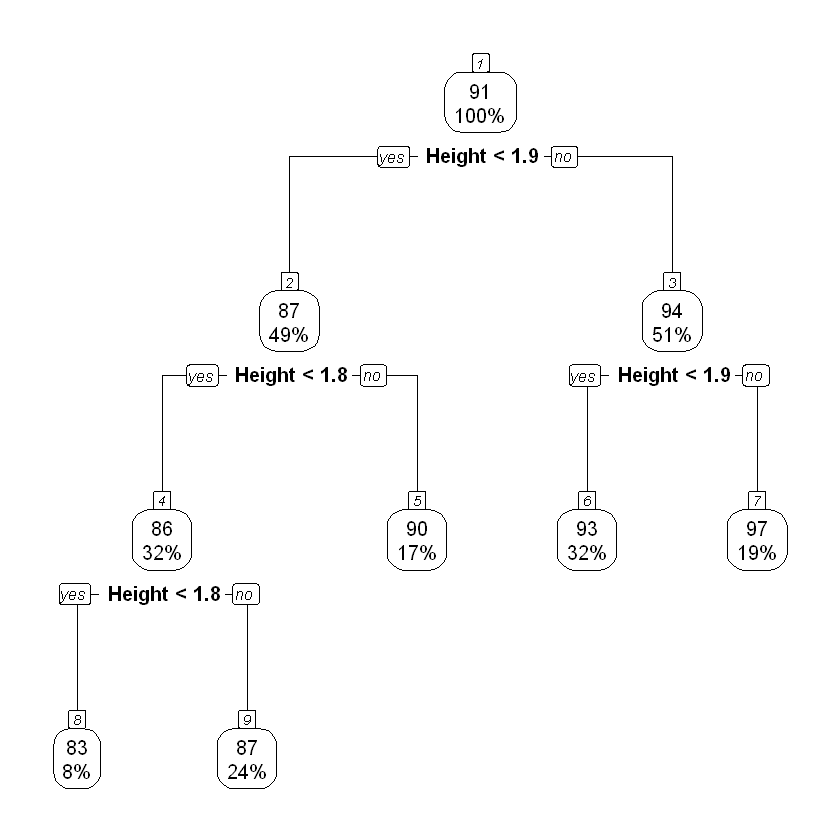

In [13]:
prp(baseball.tree, type = 2, extra = "auto", nn = TRUE, branch = 1, varlen = 0, yesno =2)

In [14]:
# Test model
pred_new = predict(baseball.tree, testData, type = "vector")

In [15]:
# mean square error 
mse = mean((testData$Weight - pred_new)^2)
print(mse)

[1] 57.84972


In [16]:
x = c(1.775, 1.825, 1.925)
y1 = predict(baseball.tree, data.frame(Height = x), type = "vector")
print(y1)

       1        2        3 
82.72491 86.67343 97.08243 
